# 실험내용
1. LLM 활용하여 full-query를 sub-query로 변환 및 각 sub-query의 사진 생성 중요도 측정
2. 모든 서브쿼리에 대해 검색을 수행하여 사진 반환
3. 검색된 사진들끼리 코사인 유사도 계산하여 코사인 유사도가 임계값보다 높을 경우 더 가중치가 높은 사진 선택
4. 필터링 된 사진과 서브쿼리만을 활용하여 이미지 생성

In [34]:
# # ! pip install faiss-cpu
# ! pip install --upgrade langchain langchain-community
# ! pip install langchain_openai


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# import faiss
import json
import  torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd

import os
import io
import requests
from PIL import Image
import PIL
from google.colab import files
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt


In [25]:
# 임베딩 CLIP 모델 정보
model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)


# text 임베딩 벡터 반환
def encode_text(text):
    inputs = processor(text=[text], return_tensors="pt")
    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)
    text_features = torch.nn.functional.normalize(text_features, p=2, dim=-1) #정규화
    return text_features.cpu().numpy().astype("float32")

# 검색
def search_similar_images(text, image_index, top_k=5):
    text_vec = encode_text(text)
    distances, indices = image_index.search(text_vec, top_k)
    # 개별 벡터 가져오기
    image_embed_vectors = []
    for i in indices[0]:  # 이차원 배열이므로 첫 번째 row에서 가져오기
      vec = np.zeros((image_index.d,), dtype=np.float32)  # 빈 벡터 생성
      image_index.reconstruct(int(i), vec)  # 특정 ID의 벡터 복원
      image_embed_vectors.append(vec) # 저장
    image_embed = torch.tensor(np.array(image_embed_vectors), dtype=torch.float32)
    return image_embed, distances

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
# 이미지 입력 받기

upload_dir = "/content/uploads"
os.makedirs(upload_dir, exist_ok=True)

# 업로드된 이미지 경로 저장
uploaded_image_paths = []

# Colab에서 이미지 파일 업로드 및 저장
def upload_images():
    uploaded_files = files.upload()
    for file_name in uploaded_files.keys():
        file_path = os.path.join("/content", file_name)  # 기본 업로드 경로
        move_path = os.path.join(upload_dir, file_name)  # 사용자 지정 디렉토리

        # 파일을 원하는 디렉토리로 이동
        os.rename(file_path, move_path)

        uploaded_image_paths.append(move_path)
        print(f"save image : {move_path}")


# 버튼 설정
upload_button = widgets.Button(description="이미지 업로드")

# 클릭 시 실행
def on_upload_clicked(b):
    upload_images()


upload_button.on_click(on_upload_clicked)

# 출력
display(upload_button)


Button(description='이미지 업로드', style=ButtonStyle())

Saving 스크린샷 2025-02-19 오후 2.16.38.png to 스크린샷 2025-02-19 오후 2.16.38.png
Saving 스크린샷 2025-02-19 오후 2.16.47.png to 스크린샷 2025-02-19 오후 2.16.47.png
save image : /content/uploads/스크린샷 2025-02-19 오후 2.16.38.png
save image : /content/uploads/스크린샷 2025-02-19 오후 2.16.47.png


In [8]:
# DB 설정
import faiss
faiss_index_filename = "/content/drive/MyDrive/SDM/dog_ad.index"  # 고화질 벡터db

# FAISS 인덱스 로드
db_index = faiss.read_index(faiss_index_filename)

### 쿼리 검색
1. query가 너무 구체적이어서 적절한 검색을 이끌어내지 못할 때
2. LLM을 활용하여 쿼리 세분화 -> 벡터 검색에 중요한 명사 위주로 뽑기?
3. 각 명사로 여러 번 뽑은 각 사진들을 활용하여 가중치 설정
4. 가중치 설정: 유사도 비례 + LLM CoT


- input_query summarize

In [12]:
query_text = "A cute dog wearing yellow hoodie sits on a stylish sofa, gazing around in a warm and cozy living room. Soft lighting fills the space, casting gentle shadows on the plush cushions. The atmosphere feels calm and inviting, with a sense of comfort and warmth."

In [14]:
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

os.environ["OPENAI_API_KEY"] = 'my_openai_key'
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

# 텍스트 입력
# input 이미지 임베딩 + 정규화
prompt_sum = f"""You are an expert in summarizing image descriptions for **dog clothing-focused visuals**. Your goal is to ensure the summary clearly highlights the **dog's outfit, its fit, and its key features** without unnecessary details.

- The summary should **focus entirely on the dog and its outfit**, without mentioning any human presence.
- The dog's **pose, expression, and setting** can be included, but the outfit should remain the central element.
- Emphasize details such as **fabric, fit, comfort, and style** to ensure clarity in the final image.
- Keep the summary **concise yet descriptive**, ensuring that the dog's outfit and its visual impact are well captured.

**Example Input:**
"A fluffy poodle wears a snug red sweater, sitting comfortably on a soft blanket. The sweater’s knitted texture and warm material make the dog look cozy and stylish. The dim lighting casts a gentle glow, enhancing the warm atmosphere."

**Example Output:**
"A poodle wearing red sweater sits on a soft blanket, highlighting its warm knitted texture and cozy fit."

Now, summarize the following description while ensuring the dog's outfit remains the primary focus:
{query_text}
"""

response = llm.invoke(prompt_sum)
summarized_query_text= response.content


In [ ]:
summarized_query_text


'A dog sits on a cushion, showcasing a stylish navy collar adorned with beige leather details. The collar features a gold-tone buckle and a matching tag, emphasizing its fashionable design.'

- weight + sub-query

In [15]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing import List
import json

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

# JSON 출력 파서를 정의
class SubQuery(BaseModel):
    query: str = Field(description="서브쿼리 내용")
    weight: float = Field(description="서브쿼리의 중요도 (0~1 범위)")

class SubQueryOutput(BaseModel):
    subqueries: List[SubQuery]

parser = JsonOutputParser(pydantic_object=SubQueryOutput)

# 서브쿼리 생성 함수
def generate_subqueries(query_text):
    prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert in **image generation and semantic search optimization**.\n\n"
            "Given the **input query**, extract the essential components that define the scene.\n"
            "Then, generate **concise subqueries** that capture the **key visual elements** of the image.\n\n"
            "Each subquery should:\n"
            "- Represent a distinct aspect of the scene (e.g., objects, actions, attributes).\n"
            "- Be **standalone** and **not depend on other subqueries**.\n"
            "- Include a **weight** (between 0 and 1) based on its importance for image generation.\n"
            "- The total sum of weights **must be exactly 1.0**.\n\n"
            "Return the output strictly in JSON format:\n"
            "{{\"subqueries\": [{{\"query\": \"Subquery1\", \"weight\": X.XX}}, "
            "{{\"query\": \"Subquery2\", \"weight\": X.XX}}, ...]}}\n"
        ),
        (
            "user",
            "#Format: {format_instructions}\n\n"
            "#Question: {query_text}"
        ),
    ]
).partial(format_instructions=parser.get_format_instructions())

    chain = prompt | llm | parser  # 체인 구성
    return chain.invoke({"query_text": query_text})

result = generate_subqueries(query_text)
# print(json.dumps(result.dict(), indent=4, ensure_ascii=False))


In [18]:
result

{'subqueries': [{'query': 'A cute dog wearing a yellow hoodie',
   'weight': 0.35},
  {'query': 'A stylish sofa', 'weight': 0.25},
  {'query': 'Warm and cozy living room', 'weight': 0.2},
  {'query': 'Soft lighting casting gentle shadows', 'weight': 0.1},
  {'query': 'Plush cushions', 'weight': 0.1}]}

In [19]:
query_list = [item['query'] for item in result['subqueries']]
weight_list = [item['weight'] for item in result['subqueries']]

In [ ]:
weight_list

[0.25, 0.15, 0.15, 0.25, 0.2]

### 코사인 유사도 검색

In [21]:
import faiss
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

# FAISS 인덱스 로드 (L2 기반 인덱스)
faiss_index_filename = "/content/drive/MyDrive/SDM/dog_ad.index"
db_index = faiss.read_index(faiss_index_filename)

# 🔹 기존 L2 인덱스를 Inner Product(IP) 기반 인덱스로 변환
# FAISS 내적 기반 인덱스를 생성하고, L2 정규화하여 적용
dimension = db_index.d  # 벡터 차원 (예: 768)
new_index = faiss.IndexFlatIP(dimension)  # Inner Product 기반 인덱스 생성

# 🔹 기존 벡터를 정규화한 후 새 인덱스에 추가
vectors = np.zeros((db_index.ntotal, dimension), dtype=np.float32)
for i in range(db_index.ntotal):
    db_index.reconstruct(i, vectors[i])  # 기존 벡터 복원
faiss.normalize_L2(vectors)  # 🔹 L2 정규화 적용
new_index.add(vectors)  # 변환된 인덱스를 FAISS에 추가

# 🔹 새 인덱스로 검색할 수 있도록 교체
db_index = new_index

# 🔹 이미지 파일 경로 로드
image_paths_filename = "/content/drive/MyDrive/SDM/dog_ad.pkl"
with open(image_paths_filename, "rb") as f:
    image_paths = pickle.load(f)


In [22]:
def search_similar_images_cosine(text, image_index, image_paths, top_k=5):
    """입력 텍스트와 가장 유사한 이미지 임베딩을 검색하는 함수"""

    text_vec = encode_text(text)  # 🔹 768차원 텍스트 벡터화
    text_vec = text_vec / np.linalg.norm(text_vec)  # 🔹 검색 벡터 정규화 (L2 Normalization)

    distances, indices = image_index.search(text_vec, top_k)  # 🔹 FAISS 검색

    # 🔹 검색된 이미지의 임베딩 벡터 복원
    image_embeddings = []
    for i in indices[0]:  # 검색된 이미지 ID 리스트
        vec = np.zeros((image_index.d,), dtype=np.float32)  # 빈 벡터 생성 (FAISS에서 벡터 복원할 공간)
        image_index.reconstruct(int(i), vec)  # 🔹 특정 ID의 벡터 복원
        image_embeddings.append(vec)

    # 🔹 NumPy 배열 → Torch Tensor 변환
    image_embeddings_tensor = torch.tensor(np.array(image_embeddings), dtype=torch.float32)

    return image_embeddings_tensor, distances  # 🔹 이미지 임베딩과 거리 반환


In [23]:
# 검색된 이미지 시각화
def display_images(image_paths):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
    for ax, img_path in zip(axes, image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")  # 축 제거
    plt.show()

# display_images(retrieved_images)

- 거리기반 검색

In [ ]:
faiss_index_filename = "/content/drive/MyDrive/SDM/dog_ad.index"
db_index = faiss.read_index(faiss_index_filename)
# 🔹 이미지 파일 경로 로드
image_paths_filename = "/content/drive/MyDrive/SDM/dog_ad.pkl"
with open(image_paths_filename, "rb") as f:
    image_paths = pickle.load(f)

In [ ]:
def search_similar_images(text, image_index, image_paths, top_k=5):
    text_vec = encode_text(text)  # 🔹 텍스트 벡터화
    distances, indices = image_index.search(text_vec, top_k)  # 🔹 FAISS 검색 (L2 거리 기반)

    # 🔹 개별 벡터 가져오기 & 이미지 경로 조회
    image_embed_vectors = []
    retrieved_image_paths = []  # 검색된 이미지 파일 경로 저장
    for i in indices[0]:  # 첫 번째 row에서 검색된 벡터 ID 가져오기
        vec = np.zeros((image_index.d,), dtype=np.float32)  # 빈 벡터 생성
        image_index.reconstruct(int(i), vec)  # 특정 ID의 벡터 복원
        image_embed_vectors.append(vec)  # 벡터 저장

        # 🔹 검색된 이미지의 실제 파일 경로 추가
        if i < len(image_paths):  # ID가 존재하는지 확인
            retrieved_image_paths.append(image_paths[i])

    # 🔹 검색된 이미지 임베딩을 Torch Tensor로 변환
    image_embed = torch.tensor(np.array(image_embed_vectors), dtype=torch.float32)

    return image_embed, distances, retrieved_image_paths


In [ ]:
def display_images(image_paths, distances):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

    for ax, img_path, distance in zip(axes, image_paths, distances[0]):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"Distance: {distance:.4f}")  # 거리값 출력
        ax.axis("off")  # 축 제거

    plt.show()


### 생성

In [26]:
# 코사인유사도 기반 검색
from scipy.special import softmax
import numpy as np

top_k = 1 # 검색할 이미지 개수

# 🔹 각 서브쿼리에 대해 FAISS 검색 수행
subquery_results = []
for subquery in query_list:
    print(f"Searching for: {subquery}")
    similar_images_emb, distances = search_similar_images_cosine(subquery, db_index,image_paths, top_k=top_k)
    subquery_results.append((subquery, similar_images_emb, distances))

Searching for: A cute dog wearing a yellow hoodie
Searching for: A stylish sofa
Searching for: Warm and cozy living room
Searching for: Soft lighting casting gentle shadows
Searching for: Plush cushions


In [35]:
# # 거리 기반 검색
# # search_similar_images(text, image_index, image_paths, top_k=5):
# subquery_results = []
# top_k = 2
# for subquery in list(subquery_dict.keys()):
#     print(f"Searching for: {subquery}")
#     image_embed, distances, retrieved_image_paths = search_similar_images(subquery, db_index,image_paths, top_k=top_k)
#     subquery_results.append((subquery, similar_images_emb, distances))

In [ ]:
### 라이브러리 파일 교체

import os
from google.colab import files

# 교체할 파일 경로
file_path = "/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/kandinsky/pipeline_kandinsky_prior.py"

# 파일 업로드
uploaded_files = files.upload()

# 업로드된 파일 처리
for file_name in uploaded_files.keys():
    # 업로드된 파일이 Python 파일인지 확인
    if file_name.endswith(".py"):
        upload_file_path = os.path.join("/content", file_name)  # Colab 기본 업로드 경로

        # 파일을 diffusers 경로로 이동하여 덮어쓰기
        os.rename(upload_file_path, file_path)

        print(f"업로드 완료")
    else:
        print(f"ERROR")



Saving pipeline_kandinsky_prior_s.py to pipeline_kandinsky_prior_s.py
업로드 완료


In [ ]:
from diffusers import KandinskyPriorPipeline, KandinskyPipeline

# 모델 불러오기
pipe_prior = KandinskyPriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-1-prior", torch_dtype=torch.float16
)
pipe_prior.to("cuda")


pipe = KandinskyPipeline.from_pretrained("kandinsky-community/kandinsky-2-1", torch_dtype=torch.float16)
pipe.to("cuda")


model_index.json:   0%|          | 0.00/500 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

image_encoder%2Fconfig.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

(…)age_processor%2Fpreprocessor_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

prior%2Fconfig.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/495M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.09G [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/626 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/767 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

movq%2Fconfig.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/318 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/271M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

tokenizer%2Ftokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You are using a model of type xlm-roberta to instantiate a model of type M-CLIP. This is not supported for all configurations of models and can yield errors.


KandinskyPipeline {
  "_class_name": "KandinskyPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "kandinsky-community/kandinsky-2-1",
  "movq": [
    "diffusers",
    "VQModel"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "kandinsky",
    "MultilingualCLIP"
  ],
  "tokenizer": [
    "transformers",
    "XLMRobertaTokenizerFast"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ]
}

### 검색된 사진들 간의 코사인 유사도 비교후 임계값을 넘을 경우 가중치가 더 높은 사진을 선택하는 방법

In [29]:
weighted_results = []
# subquery_results의 각 항목과 인덱스를 사용하여 순서대로 weight를 가져옵니다.
for idx, (subquery, image_emb, distances) in enumerate(subquery_results):
    # 서브쿼리의 중요도를 순서대로 가져옴
    weight = weight_list[idx]

    # 거리값을 배열로 변환 후 정규화
    weights = np.array(distances[0])
    normalized_weights = weights / np.sum(weights)

    # 서브쿼리의 중요도(weight)를 곱하여 최종 가중치 계산
    top_k_w = normalized_weights * weight

    # 결과 저장
    weighted_results.append((subquery, image_emb, top_k_w.tolist()))

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from itertools import combinations

def filter_similar_images(weighted_results, similarity_threshold=0.8):
    filtered_results = []
    selected_indices = set()  # 제거할 인덱스 저장

    # 이미지 임베딩과 가중치 추출 (2D 변환)
    embeddings = np.array([np.squeeze(result[1]) for result in weighted_results])  # (n, embedding_dim)
    weights = [np.sum(result[2]) for result in weighted_results]  # 각 서브쿼리의 가중치 합산

    # 모든 가능한 쌍 조합 생성
    similarity_matrix = cosine_similarity(embeddings)

    print("\nAll Pairwise Similarities:")
    for i, j in combinations(range(len(weighted_results)), 2):  # 모든 쌍 탐색
        print(f"Similarity between {weighted_results[i][0]} and {weighted_results[j][0]}: {similarity_matrix[i, j]:.4f}")

        if i in selected_indices or j in selected_indices:
            continue  # 이미 선택에서 제외된 경우 무시

        if similarity_matrix[i, j] > similarity_threshold:  # 유사도 임계값 초과 여부 확인
            if weights[i] >= weights[j]:
                selected_indices.add(j)  # 가중치가 낮은 항목 제거
            else:
                selected_indices.add(i)

    # 최종 선택된 이미지만 필터링
    for i in range(len(weighted_results)):
        if i not in selected_indices:
            filtered_results.append(weighted_results[i])

    return filtered_results

# 필터링 적용
filtered_results = filter_similar_images(weighted_results)



All Pairwise Similarities:
Similarity between A cute dog wearing a yellow hoodie and A stylish sofa: 0.5764
Similarity between A cute dog wearing a yellow hoodie and Warm and cozy living room: 0.5069
Similarity between A cute dog wearing a yellow hoodie and Soft lighting casting gentle shadows: 0.5219
Similarity between A cute dog wearing a yellow hoodie and Plush cushions: 0.6535
Similarity between A stylish sofa and Warm and cozy living room: 0.7451
Similarity between A stylish sofa and Soft lighting casting gentle shadows: 0.5712
Similarity between A stylish sofa and Plush cushions: 0.8309
Similarity between Warm and cozy living room and Soft lighting casting gentle shadows: 0.6078
Similarity between Warm and cozy living room and Plush cushions: 0.7417
Similarity between Soft lighting casting gentle shadows and Plush cushions: 0.7265


In [31]:
len(filtered_results)
[x[0] for x in filtered_results]

['A cute dog wearing a yellow hoodie',
 'A stylish sofa',
 'Warm and cozy living room',
 'Soft lighting casting gentle shadows']

In [32]:

# 🔹 `similar_images_emb`와 `top_k_w`를 저장할 리스트 초기화
similar_images_emb_list = []
top_k_w_list = []

for subquery, image_embeddings, weights in filtered_results:
    # 이미지 임베딩을 NumPy 배열로 변환하여 저장
    similar_images_emb_list.extend(image_embeddings.cpu().numpy())  # 리스트에 추가

    # 가중치도 NumPy 배열로 변환하여 저장
    top_k_w_list.extend(weights)  # 가중치는 이미 리스트 형태이므로 바로 추가 가능

# 🔹 NumPy 배열 변환
similar_images_emb_array = np.array(similar_images_emb_list, dtype=np.float32)  # (전체 이미지 개수, 768)
top_k_w_array = np.array(top_k_w_list, dtype=np.float32)  # (전체 이미지 개수,)

# 🔹 PyTorch Tensor 변환 및 CUDA 이동
similar_images_emb = torch.tensor(similar_images_emb_array, dtype=torch.float32).to("cuda", dtype=torch.float16)
top_k_w = torch.tensor(top_k_w_array, dtype=torch.float32).to("cuda", dtype=torch.float16)


In [ ]:
normalized_top_k_w_list = top_k_w_list / np.sum(top_k_w_list)

In [ ]:
normalized_top_k_w_list

array([0.29411764, 0.17647059, 0.29411764, 0.23529412])

In [ ]:
np.mean(normalized_top_k_w_list)
summarized_query_text
input_images = [Image.open(path).convert("RGB") for path in uploaded_image_paths] # 입력 이미지 리스트



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([1, 768])
torch.Size([1, 768])
add top k image
10
torch.Size([1, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

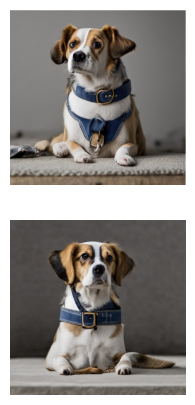

In [ ]:
# 텍스트 가중치
# query_text_w = np.mean(normalized_top_k_w_list) # 평균
# cond_image_w = np.max(normalized_top_k_w_list) # 최댓값
cond_image_w=0.4
# 생성 이미지 개수
num_images_per_prompt = 2

# image_text 컨디션 리스트
images_texts = [x[0] for x in filtered_results]+ input_images

# 가중치 설정
weights = list(normalized_top_k_w_list)+[cond_image_w/(len(input_images)) for _ in input_images]

prompt = summarized_query_text
prior_out = pipe_prior.interpolate(images_texts,
                                   weights,
                                   search_k=True,
                                   top_k_image = similar_images_emb,
                                   top_k_w =normalized_top_k_w_list)

"""
변수 설명
image_text : 이미지+텍스트 컨디션 리스트
weight : 이미지+텍스트 컨디션 가중치
search_k : 최근접 이미지 k를 삽입할 것인지 여부 (bool)
top_k_image : 찾은 최근접 이미지 벡터
top_k_w : 최근접 이미지 가중치
"""


new_image_add = pipe(prompt, **prior_out, height=768, width=768, num_images_per_prompt=num_images_per_prompt).images
#prior_out은 image_embs + negative image embs로 구성됨
# 여기서도  매개변수 지정 가능
"""
num_images_per_prompt : 생성할 이미지 개수
guidance_scale : prompt 집중 정도
"""
if num_images_per_prompt > 1:
  plt.figure(figsize=(10,5))
  for i in range(len(new_image_add)):
    plt.subplot(2, round(len(new_image_add)/2), i+1)
    plt.imshow(new_image_add[i])
    plt.axis('off')
  plt.show()
else:
  plt.imshow(new_image_add)
  plt.axis('off')
  plt.show()



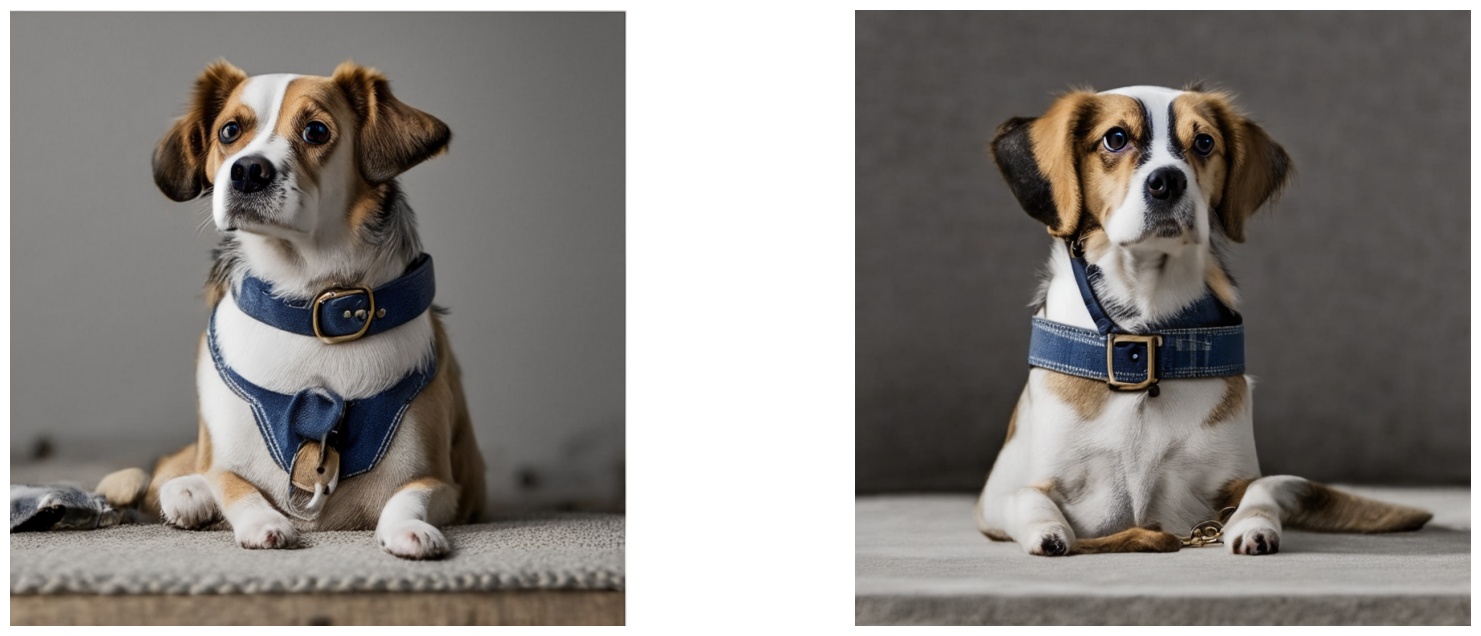

In [ ]:
if num_images_per_prompt > 1:
  plt.figure(figsize=(20,8))
  for i in range(len(new_image_add)):
    plt.subplot(round(len(new_image_add)/2),2 ,i+1 )
    plt.imshow(new_image_add[i])
    plt.axis('off')
  plt.show()
else:
  plt.imshow(new_image_add)
  plt.axis('off')
  plt.show()



In [ ]:
# 생성 이미지 개수
num_images_per_prompt = 2

prompt = query_text

negative_prompt = "low quality, bad quality" # negative 프롬프트 포함은 선택
image_embeds, negative_image_embeds = pipe_prior(prompt, negative_prompt).to_tuple()

new_image_onlytext = pipe(prompt, image_embeds=image_embeds, negative_image_embeds=negative_image_embeds, height=768, width=768, num_images_per_prompt=num_images_per_prompt).images

if num_images_per_prompt > 1:
  plt.figure(figsize=(10,5))
  for i in range(len(new_image_onlytext)):
    plt.subplot(2, round(len(new_image_onlytext)/2), i+1)
    plt.imshow(new_image_onlytext[i])
    plt.axis('off')
    plt.show()
else:
  plt.imshow(new_image_onlytext)
  plt.axis('off')
  plt.show()



 ## 성능 평가
 - clip-score

In [ ]:
# CLIP Score - text

model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)


# 텍스트와 생성 이미지 사이 유사도 평균을 반환
def c_clip_score_text(images, prompt):
    # 생성 이미지를 변환
    image_list = [image.convert("RGB") for image in images ]

    # CLIP Processor를 사용하여 입력 변환
    text_inputs = processor(text=[prompt], return_tensors="pt", padding=True)
    image_inputs = processor(images=image_list, return_tensors="pt", padding=True)


    with torch.no_grad():
        text_emb = clip_model.get_text_features(**text_inputs)
        image_emb = clip_model.get_image_features(**image_inputs)  # 이미지-텍스트 유사도 점수


    # 정규화
    text_emb =  torch.nn.functional.normalize(text_emb, p=2, dim=-1) # L2 정규화
    image_emb =  torch.nn.functional.normalize(image_emb, p=2, dim=-1) # L2 정규화

    # 유사도 계산을 위한 차원 확장
    text_emb = text_emb.expand(image_emb.shape[0], -1)  # (n, 768)

    # 코사인 유사도 계산
    similarity = torch.nn.functional.cosine_similarity(text_emb, image_emb, dim=-1)

    return similarity.mean()  # 평균

# CLIP Score 비교
clip_score_text = c_clip_score_text(new_image_onlytext, query_text)
clip_score_added_cond = c_clip_score_text(new_image_add, query_text)

print(f"CLIP Score only text: {clip_score_text:.4f}")
print(f"CLIP Score with image: {clip_score_added_cond:.4f}")


In [ ]:
# CLIP Score - image

# 입력 이미지 임베딩 벡터와 생성 이미지 사이의 유사도를 반환
def c_clip_score_image(images, input_emb):

    # 생성 이미지를 변환
    image_list = [image.convert("RGB") for image in images ]

    # CLIP Processor를 사용하여 생성된 이미지를 변환
    image_inputs_g = processor(images=image_list, return_tensors="pt", padding=True)


    with torch.no_grad():
        image_emb = clip_model.get_image_features(**image_inputs_g) # 임베딩 벡터 생성


    image_emb =  torch.nn.functional.normalize(image_emb, p=2, dim=-1) # L2 정규화

    # 유사도 계산을 위한 차원 확장
    input_emb = input_emb.expand(image_emb.shape[0], -1)  # (n, 768)

    # 코사인 유사도 계산
    similarity = torch.nn.functional.cosine_similarity(input_emb, image_emb, dim=-1)

    return similarity.mean()  # 평균 반환

# 입력 이미지 벡터로 변환
image_inputs = processor(images=input_images, return_tensors="pt", padding=True)
with torch.no_grad():
  image_embeddings = clip_model.get_image_features(**image_inputs)
image_embeddings =  torch.nn.functional.normalize(image_embeddings, p=2, dim=-1) # L2 정규화

# CLIP Score 비교
for i, emb in enumerate(image_embeddings):
  print(f'입력 이미지 경로 :  {uploaded_image_paths[i]}')
  score = c_clip_score_image(new_image_add, emb)
  print(f'CLIP Score with image : {score:.4f}')

  score = c_clip_score_image(new_image_onlytext, emb)
  print(f'CLIP Score only text: {score:.4f}')

In [ ]:
uploaded_image_paths